In [1]:
%matplotlib inline

import sys, os, time
from itertools import product

import rasterio as rio
import rasterio.mask as masker
import rasterio.plot as rplt
import rasterio.features
import rasterio.warp
import rasterio.windows as wnd

import fiona
import shapefile as shp
import matplotlib.pyplot as plt
import matplotlib.collections as clt
import numpy as np
import seaborn as sns
from descartes import PolygonPatch

In [2]:
def plot_shape(shape):
    figsize = (10,6)
    sns.set(style="whitegrid", palette="pastel", color_codes=True)
    sns.mpl.rc("figure", figsize=figsize)
    plt.figure(figsize = figsize)
    x = [i[0] for i in biggest.points]
    y = [i[1] for i in biggest.points]
    plt.plot(x, y, 'k')
    plt.show()
    
def get_tiles(dataset, width=512, height=512):
    ncols, nrows = dataset.meta['width'], dataset.meta['height']
    offsets = product(range(0, ncols, width), range(0, nrows, height))
    big_window = wnd.Window(col_off=0, row_off=0, width=ncols, height=nrows)
    
    for col_off, row_off in offsets:
        window = wnd.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
        transform = wnd.transform(window, dataset.transform)
        yield window, transform

# returns a partition of a landsat tile
def get_tile(file, width=512, height=512, col_off=0, row_off=0):
    with rio.open(file, dtype='float32') as data:
        meta = data.meta.copy()
        # consider using profile here.
        
        ncols, nrows = meta['width'], meta['height']
        offsets = product(range(0, ncols, width), range(0, nrows, height))
        big_window = wnd.Window(col_off=0, row_off=0, width=ncols, height=nrows)
    
        window = wnd.Window(col_off=col_off * width, row_off=row_off * height, width=width, height=height).intersection(big_window)
        transform = wnd.transform(window, data.transform)
        
        meta['transform'] = transform
        meta['width'], meta['height'] = window.width, window.height
        return data.read(window=window).transpose(1,2,0).astype(float), meta
    

In [3]:
landsatTileList = r"/home/dsa/DSA/images/scene_list.txt"
landsatDirectory = r"/home/dsa/DSA/images/corrected/LC82201072015017LGN00"
coastMaskShpfile = r"/home/dsa/DSA/vectors/Coastline_high_res_polygon_v7.1.shp"

outputDirectory = r"/home/dsa/DSA/vectors/"
outputFileExt = r"_burjo_output.tif"

assert os.path.isfile(landsatTileList)
assert os.path.isdir(landsatDirectory)
assert os.path.exists(landsatDirectory)
assert os.path.isfile(coastMaskShpfile)
os.listdir(landsatDirectory)

['.fuse_hidden000000a50000001b',
 '.fuse_hidden000000b400000024',
 'LC82201072015017LGN00full_color_seg.tif',
 'LC82201072015017LGN00_B1.TIF',
 'LC82201072015017LGN00_B10.TIF',
 'LC82201072015017LGN00_B11.TIF',
 'LC82201072015017LGN00_B2.TIF',
 'LC82201072015017LGN00_B3.TIF',
 'LC82201072015017LGN00_B4.TIF',
 'LC82201072015017LGN00_B5.TIF',
 'LC82201072015017LGN00_B6.TIF',
 'LC82201072015017LGN00_B7.TIF',
 'LC82201072015017LGN00_burjo_output.tif',
 'LC82201072015017LGN00_burjo_output.tif.aux.xml']

In [4]:
tiles = open(landsatTileList).read().splitlines()

In [5]:
startTime = time.ctime()

In [6]:
print("ArcPy Rock masking script started: %s" % startTime)

ArcPy Rock masking script started: Wed Oct 16 09:13:10 2019


Extracting the main continent polygon from the ADD shapefile.
This is commented out as our test image is landlocked.

In [ ]:
schema = {'geometry': 'Polygon', 'properties': {'area': 'float:13.3', 'id_img': 'int', 'id_ADD':'int'}}

with fiona.open(outputDirectory + "test_clip.shp", 'w', driver='ESRI Shapefile', schema=schema) as coast_clip:
    for boundingbox in 


In [7]:
for i in range(len(tiles)):
    
    thisTileID = tiles[i]
    thisTileFile = landsatDirectory + "/" + thisTileID
    outFilename = outputDirectory + "/" + thisTileID
    
    fmt = "\t%d of %d."
    print(fmt % (i + 1, len(tiles)))
    tic = time.time()

	1 of 1.


Normally all cells below will be inside the for loop above.
For testing purposes with a single tile they've been removed from the
for block.

Extract bands needed for masks from section with rocks (column and row
offset arbitrarily selected for test partition)

(-2313255.0, 921135.0)	(-2313255.0, 905775.0)
(-2297895.0, 921135.0)	(-2297895.0, 905775.0)


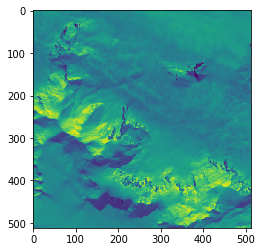

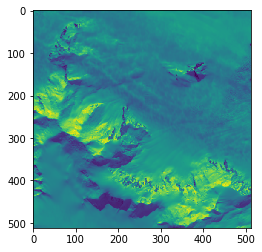

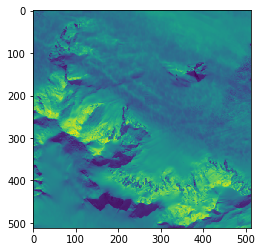

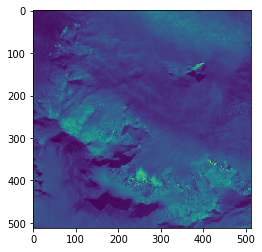

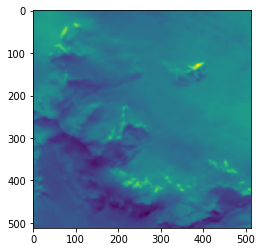

In [8]:
col_off = 11
row_off = 13
B2, B2_meta = get_tile(thisTileFile + "_B2.TIF", col_off=col_off, row_off=row_off)
B2_transform = B2_meta['transform']

B3, B3_meta = get_tile(thisTileFile + "_B3.TIF", col_off=col_off, row_off=row_off)

B4, B4_meta = get_tile(thisTileFile + "_B4.TIF", col_off=col_off, row_off=row_off)

B5, B5_meta = get_tile(thisTileFile + "_B5.TIF", col_off=col_off, row_off=row_off)

B6, B6_meta = get_tile(thisTileFile + "_B6.TIF", col_off=col_off, row_off=row_off)

B10, B10_meta = get_tile(thisTileFile + "_B10.TIF", col_off=col_off, row_off=row_off)

top_left = B2_transform * (0,0)
top_right = B2_transform * (0, 512)
bottom_left = B2_transform * (512, 0)
bottom_right = B2_transform * (512, 512)
print("{}\t{}\n{}\t{}".format(top_left, top_right, bottom_left, bottom_right))
rplt.show(B2)
rplt.show(B3)
rplt.show(B5)
rplt.show(B6)
rplt.show(B10)

In [ ]:
with shp.Reader(coastMaskShpfile) as coast:
    biggest = max(coast.shapes(), key=lambda x: len(x.points))

In [ ]:
with rio.open(thisTileFile + "_B2.TIF", dtype='float32') as data:
    B2_whole = data.read(1)
    B2_whole_transform = data.transform
    B2_whole_bounds = data.bounds
    #B2_clip, B2_clip_transform = masker.mask(data,  
                                         #    biggest, crop=True)
    #B2_clip_meta = data.meta

In [ ]:
B2_clip_meta.update({"driver": "GTiff",
                        "height": B2_clip.shape[1],
                        "width": B2_clip.shape[2],
                        "transform": B2_clip_transform})
with rasterio.open(thisTileFile + "_B2_CoastClip.TIF", "w", **B2_clip_meta) as dest:
    dest.write(B2_clip)

In [ ]:
print(B2_whole_bounds)

In [ ]:
poly = biggest.__geo_interface__
ax = plt.gca()
ax.add_patch(PolygonPatch(poly, edgecolor='red', facecolor='none', linewidth=1))
ax.axis('scaled')
rplt.show(B2_whole, transform=B2_whole_transform, ax=ax)

Create normalized versions of bands to display full color image

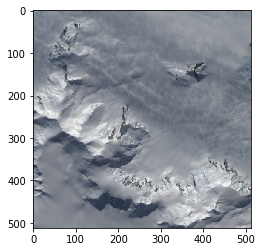

In [9]:
B2_norm = (B2 * (255.0/ B2.max())).astype(int)
B3_norm = (B3 * (255.0/ B3.max())).astype(int)
B4_norm = (B4 * (255.0/ B4.max())).astype(int)
full_color = np.dstack((B4_norm, B3_norm, B2_norm))
plt.imshow(full_color)

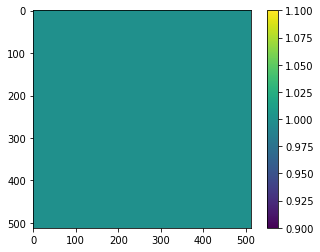

In [10]:
# The example tile is landlocked. skipping coastline mask for now
coastMaskBin = (B2 > 0).astype(int)

plt.imshow(coastMaskBin.squeeze())
plt.colorbar()

In [11]:
toc = time.time()
print(" Loaded & Coast Masked (%.02fs)." % (toc - tic))
tic = time.time()

 Loaded & Coast Masked (23.45s).


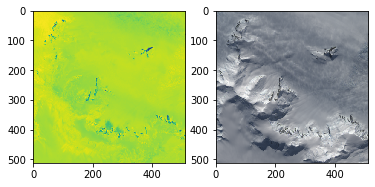

In [12]:
ndsi = (B3 - B6) / (B3 + B6)
fig, axes = plt.subplots(1,2)
im = axes[0].imshow(ndsi.squeeze())
im2 = axes[1].imshow(full_color)

plt.show()

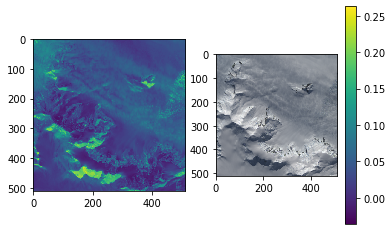

In [13]:
ndwi = (B3 - B5) / (B3 + B5)

fig, axes = plt.subplots(1,2)
im = axes[0].imshow(ndwi.squeeze())
im2 = axes[1].imshow(full_color)
plt.colorbar(im)
plt.show()

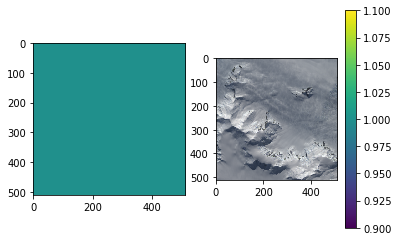

In [14]:
mask1_step1 = ((B10 / B2) > 0.4).astype(int)

fig, axes = plt.subplots(1,2)
im = axes[0].imshow(mask1_step1.squeeze())
im2 = axes[1].imshow(full_color)
plt.colorbar(im)
plt.show()


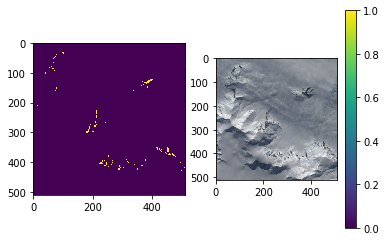

In [32]:
mask1_step2 = (ndsi < 0.70).astype(int)

fig, axes = plt.subplots(1,2)
im = axes[0].imshow(mask1_step2.squeeze())
im2 = axes[1].imshow(full_color)
plt.colorbar(im)
plt.show()


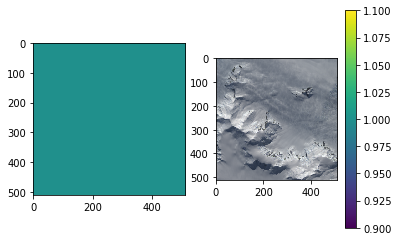

In [33]:
mask1_step3 = (ndwi < 0.45).astype(int)

fig, axes = plt.subplots(1,2)
im = axes[0].imshow(mask1_step3.squeeze())
im2 = axes[1].imshow(full_color)
plt.colorbar(im)
plt.show()

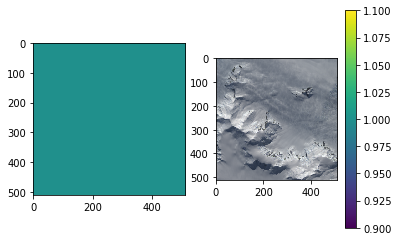

In [34]:
mask1_step5 = (B10 > 2550.0).astype(int) # Note: this is a scaled value

fig, axes = plt.subplots(1,2)
im = axes[0].imshow(mask1_step5.squeeze())
im2 = axes[1].imshow(full_color)
plt.colorbar(im)
plt.show()

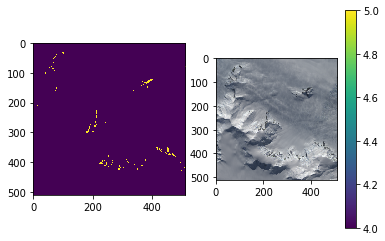

In [35]:
mask1_prefinal = mask1_step1 + mask1_step2 + mask1_step3 + coastMaskBin + mask1_step5

fig, axes = plt.subplots(1,2)
im = axes[0].imshow(mask1_prefinal.squeeze())
im2 = axes[1].imshow(full_color)
plt.colorbar(im)
plt.show()

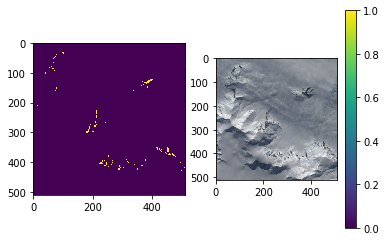

In [36]:
mask1_final = (mask1_prefinal == 5).astype(int)

fig, axes = plt.subplots(1,2)
im = axes[0].imshow(mask1_final.squeeze())
im2 = axes[1].imshow(full_color)
plt.colorbar(im)
plt.show()

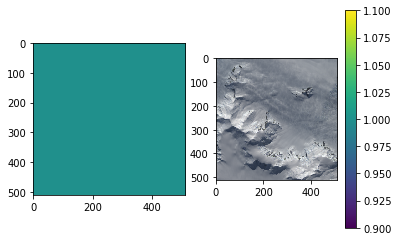

In [37]:
mask2_step1 = (B2 < 2500.0).astype(int) # note this is a scaled value

fig, axes = plt.subplots(1,2)
im = axes[0].imshow(mask2_step1.squeeze())
im2 = axes[1].imshow(full_color)
plt.colorbar(im)
plt.show()

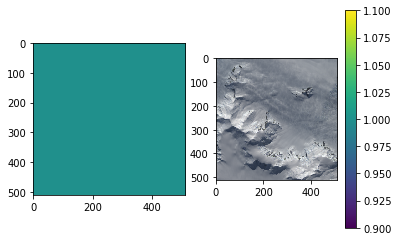

0.2630129031756288


In [38]:
mask2_step2 = (ndwi < 0.45).astype(int)

fig, axes = plt.subplots(1,2)
im = axes[0].imshow(mask2_step2.squeeze())
im2 = axes[1].imshow(full_color)
plt.colorbar(im)
plt.show()
print(ndwi.max())

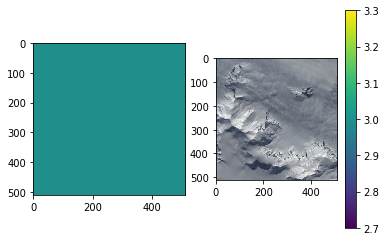

In [39]:
mask2_prefinal = mask2_step1 + mask2_step2 + coastMaskBin

fig, axes = plt.subplots(1,2)
im = axes[0].imshow(mask2_prefinal.squeeze())
im2 = axes[1].imshow(full_color)
plt.colorbar(im)
plt.show()

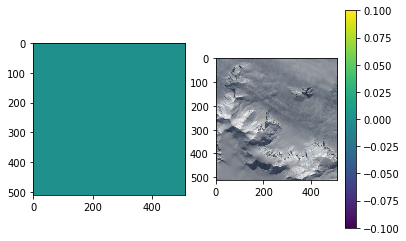

In [40]:
mask2_final = 1 - (mask2_prefinal == 3).astype(int)

fig, axes = plt.subplots(1,2)
im = axes[0].imshow(mask2_final.squeeze())
im2 = axes[1].imshow(full_color)
plt.colorbar(im)
plt.show()

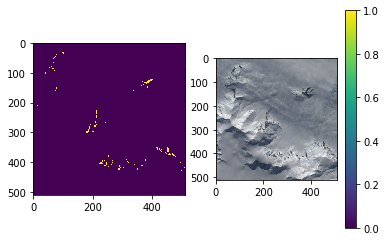

In [41]:
mask_prefinal = mask1_final + mask2_final

fig, axes = plt.subplots(1,2)
im = axes[0].imshow(mask_prefinal.squeeze())
im2 = axes[1].imshow(full_color)
plt.colorbar(im)
plt.show()

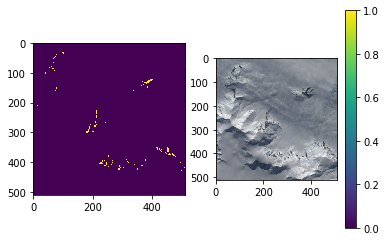

In [42]:
mask_final = (mask_prefinal > 0).astype(int)

fig, axes = plt.subplots(1,2)
im = axes[0].imshow(mask_final.squeeze())
im2 = axes[1].imshow(full_color)
plt.colorbar(im)
plt.show()

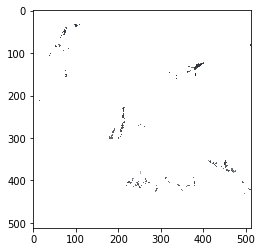

In [43]:
mask_final_norm = mask_final * 255
full_color_masked = np.dstack((B4_norm, B3_norm, B2_norm, mask_final_norm))
plt.imshow(full_color_masked)

In [44]:
output_mask = mask_final.transpose(2, 0, 1)
B2_meta['dtype'] = rio.uint16
B2_meta['count'] = 1

with rio.open(landsatDirectory + "/" + thisTileID + outputFileExt, 'w', **B2_meta) as dst:
        dst.write(output_mask.astype(rio.uint16))

In [28]:
full_color_ref = np.dstack((B4_norm, B3_norm, B2_norm)).transpose(2, 0, 1)
color_meta = B2_meta
color_meta['count'] = 3
color_meta['dtype'] = rio.uint16
with rio.open(landsatDirectory + "/" + thisTileID + "full_color_seg.tif", "w", **color_meta) as col_out:
    col_out.write(full_color_ref.astype(rio.uint16))